Double deep q learning

The difference between DDQN and DQN:
- In DQN, the same network is used to select the best action and to estimate the value of that action. This can lead to an overoptimistic estimation of Q-values, which may result in suboptimal policies.
- DDQN decouples the action selection and action value estimation by using two separate networks: the online Q-network (with weights θ) and the target Q-network (with weights θ').
  - the online Q-network is used to select the best action, the target Q-network is used to estimate the value of that action
  - the target value computation in DDQN is as follows:
    - use the online Q to select the best action
    - use the target Q to estimate the value of taking this action
    - compute the target value using Bellman optimality with the target Q-network
  - the online Q network is updated as DQN, and the target Q-network is updated periodically by copying the weights from the online Q-network.
 

In [1]:
import gymnasium as gym
import jax
import jax.numpy as jnp
import numpy as np
from collections import deque
import random
from flax import linen as nn
import optax
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
class QNetwork(nn.Module):
    action_size: int
    
    def setup(self):
        self.dense1 = nn.Dense(features=256)
        self.dense2 = nn.Dense(features=256)
        self.dense3 = nn.Dense(features=256)
        self.dense4 = nn.Dense(features=self.action_size)

    def __call__(self, x):
        x = nn.relu(self.dense1(x))
        x = nn.relu(self.dense2(x))
        x = nn.relu(self.dense3(x))
        x = self.dense4(x)
        return x

In [3]:
class DDQNAgent:
    def __init__(self, state_size, action_size, rng_key, buffer_size=10000, batch_size=64, gamma=0.99, lr=1e-3, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=buffer_size)

        rng_key, rng_key_init = jax.random.split(rng_key)
        self.network, self.params, self.optimizer, self.opt_state = self.initialize_network_and_optimizer(rng_key_init)
        self.target_params = self.params
        self.tau = 0.001
        self.steps = 0

        # debug
        self.losses = []
        self.grads = []
    
    def initialize_network_and_optimizer(self, rng):
        network = QNetwork(self.action_size)
        params = network.init(rng, jnp.ones((self.state_size,)))
        optimizer = optax.adam(self.lr)
        opt_state = optimizer.init(params)
        return network, params, optimizer, opt_state

    def sync_target(self):
        #self.target_params = self.params
        # this is soft update for each step
        self.target_params = jax.tree_map(lambda x, y: self.tau * x + (1 - self.tau) * y, self.params, self.target_params)

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            state = jnp.expand_dims(jnp.array(state, dtype=jnp.float32), axis=0)
            q_values = self.network.apply(self.params, state)
            return int(jnp.argmax(q_values))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

        states = jnp.array(states, dtype=jnp.float32)
        actions = jnp.array(actions, dtype=jnp.int32)
        rewards = jnp.array(rewards, dtype=jnp.float32)
        next_states = jnp.array(next_states, dtype=jnp.float32)
        dones = jnp.array(dones, dtype=jnp.float32)

        def loss(params):
            # (s,a,r,s')
            # Q(s)
            q_values = self.network.apply(params, states)
            # Q(s,a)
            q_values = jnp.take_along_axis(q_values, actions[:, None], axis=-1).squeeze()#jax.vmap(lambda s: s[actions])(q_values)

            # Q(s')
            online_q_next = self.network.apply(params, next_states)
            # Q'(s')
            target_q_next = self.network.apply(self.target_params, next_states)
            
            # a' = argmax_a(Q(s'))
            next_action = jnp.argmax(online_q_next, axis=-1)
            # Q'(s', a')
            q_target_next = jnp.take_along_axis(target_q_next, next_action[:, None], axis=-1).squeeze()
            # target: r + gamma*Q'(s', a')
            targets = rewards + self.gamma * (1 - dones) * q_target_next
            
            return jnp.mean((targets - q_values) ** 2)

        grad_fn = jax.value_and_grad(loss)
        loss_value, gradients = grad_fn(self.params)
        updates, self.opt_state = self.optimizer.update(gradients, self.opt_state)
        self.params = optax.apply_updates(self.params, updates)
        self.losses.append(loss_value)
        self.grads.append(gradients)
        #self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        #print(self.epsilon)
        self.steps += 1


In [4]:
# RC model parameters
rc_params = [6.9789902e+03, 2.1591113e+04, 1.8807944e+05, 3.4490612e+00, 4.9556872e-01, 9.8289281e-02, 4.6257420e+00]
x0 = np.array([20, 35.8, 26.])
x_high = np.array([40., 80., 40.])
x_low = np.array([10., 10., 10.])
n_actions = 101
u_high = [0]
u_low = [-10.0] # -12

# load disturbances
file_path = os.path.abspath('')
parent_path = os.path.dirname(file_path)
data_path = os.path.join(parent_path, 'data/disturbance_1min.csv')
data = pd.read_csv(data_path, index_col=[0])
# assign time index
t_base = 181*24*3600 # 7/1
n = len(data)
index = range(t_base, t_base + n*60, 60)
data.index = index

# sample
dt = 900
data = data.groupby([data.index // dt]).mean()
index_dt = range(t_base, t_base + len(data)*dt, dt)
data.index = index_dt 

# get disturbances for lssm
t_d = index_dt
disturbance_names = ['out_temp', 'qint_lump', 'qwin_lump', 'qradin_lump']
disturbance = data[disturbance_names].values


In [5]:
# random seed
seed = 0
np.random.seed(seed)

# Train the agent
import env
ts = 195*24*3600
ndays = 7
te = ndays*24*3600 + ts
weights = [1., 1., 1.] # for energy cost, dT, du
cop = 1.0

env = gym.make("R4C3Discrete-v0",
            rc_params = rc_params,
            x0 = x0,
            x_high = x_high,
            x_low = x_low,
            n_actions = n_actions,
            u_high = u_high,
            u_low = u_low,
            disturbances = (t_d, disturbance),
            cop = cop,
            ts = ts,
            te = te,
            dt = dt,
            weights = weights).env

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
rng_key = jax.random.PRNGKey(42)
lr = 1e-03

agent = DDQNAgent(state_size, action_size, rng_key, lr=lr)

n_episodes = 500
reward_history = []
max_episode_steps=200 # env.spec.max_episode_steps
reward_threshold=175 # env.spec.reward_threshold
solved_window = 20
 
# sync target q-network
steps_since_target_update = 0
target_update_freq = 1

# main loop
for episode in range(n_episodes):
    state, _ = env.reset()
    state = jnp.array(state, dtype=jnp.float32)

    total_reward = 0
    done = False
    step_in_episode = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = jnp.array(next_state, dtype=jnp.float32)

        agent.remember(state, action, reward, next_state, done)
        agent.replay()

        state = next_state
        total_reward += reward
        step_in_episode += 1

        # update  target q-network 
        steps_since_target_update += 1
        if steps_since_target_update >= target_update_freq:
            agent.sync_target()
            steps_since_target_update = 0
  
        # udpate epsiolon after episode
        if done:
            if agent.epsilon > agent.epsilon_end:
                agent.epsilon *= agent.epsilon_decay
    
    reward_history.append(total_reward)
    print(f"Episode {episode}, Total Reward: {total_reward}")

    # stop training if average reward reaches requirement
    # Calculate the average reward over the last 'solved_window' episodes
    if episode >= solved_window:
        avg_reward = np.mean(reward_history[-solved_window:])
        print(f'Episode: {episode}, Average Reward: {avg_reward}')

        if avg_reward >= reward_threshold:
            print(f"CartPole-v1 solved in {episode} episodes!")
            break

# Plot the historical rewards
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Historical Rewards for CartPole-v1")
plt.show()

/opt/conda/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


env is reset!


/opt/conda/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:181: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Episode 0, Total Reward: -292.18957295032095
env is reset!
Episode 1, Total Reward: -294.97303672562566
env is reset!
Episode 2, Total Reward: -301.5256765336993
env is reset!
Episode 3, Total Reward: -285.9838331711981
env is reset!
Episode 4, Total Reward: -306.5467398860621
env is reset!
Episode 5, Total Reward: -284.69513093533067
env is reset!
Episode 6, Total Reward: -295.2672237823927
env is reset!
Episode 7, Total Reward: -308.8359580116687
env is reset!
Episode 8, Total Reward: -277.10725287139195
env is reset!
Episode 9, Total Reward: -269.5831417444807
env is reset!
Episode 10, Total Reward: -284.5816725332917
env is reset!
Episode 11, Total Reward: -283.26105928177844
env is reset!
Episode 12, Total Reward: -280.7894593162378
env is reset!
Episode 13, Total Reward: -275.97826039230637
env is reset!
Episode 14, Total Reward: -288.3920287178809
env is reset!
Episode 15, Total Reward: -274.33293332183956
env is reset!
Episode 16, Total Reward: -281.47900878230547
env is reset!

KeyboardInterrupt: 

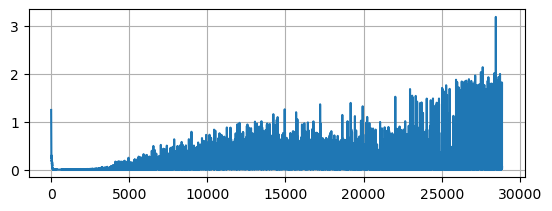

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(agent.losses)
plt.grid()


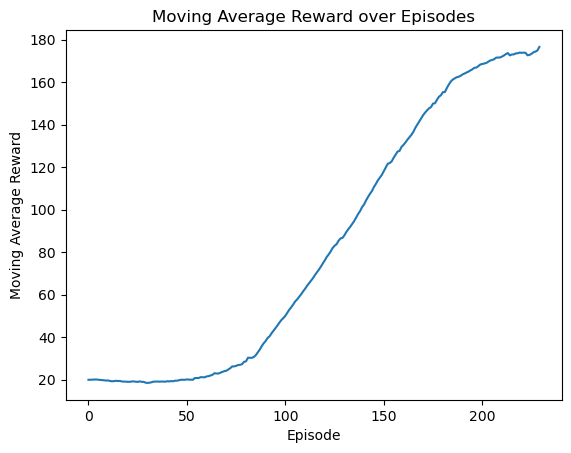

In [ ]:
# plot training 
def plot_moving_average_reward(episode_rewards, window_size=20):
    cumsum_rewards = np.cumsum(episode_rewards)
    moving_avg_rewards = (cumsum_rewards[window_size:] - cumsum_rewards[:-window_size]) / window_size

    plt.plot(moving_avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Moving Average Reward')
    plt.title('Moving Average Reward over Episodes')
    plt.show()

plot_moving_average_reward(reward_history)


In [ ]:
agent.steps

28863

Test Episode, Total Reward: 138.0


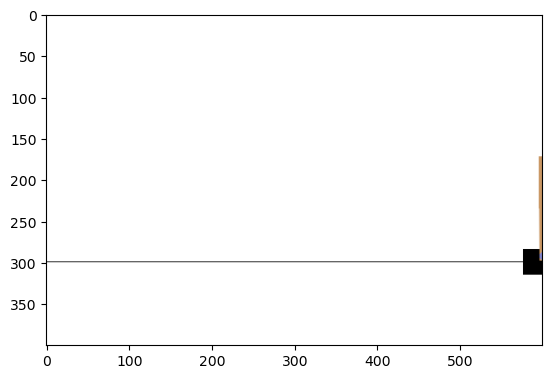

In [ ]:
# Test the trained agent
print("\nTesting the trained agent...")

state, _ = env.reset()
state = jnp.array(state, dtype=jnp.float32)

total_reward = 0
done = False

while not done:
    action = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    next_state = jnp.array(next_state, dtype=jnp.float32)
    state = next_state
    total_reward += reward

print(f"Test Episode, Total Reward: {total_reward}")

env.close()